# Customer Churn Analysis - Predictive Modeling (Logistic Regression and Decision Tree)
> In this blog, we will create Logistic Regression and Decision Tree Models to predict the customer churn probability based on the historical churn data having customer demographics and purchase patterns.

- toc: true
- comments: true
- categories: [python, churn, retention, classification modeling, churn probability, sklearn, LogisticRegression, DecisionTreeClassifier]

## Loading the Data

Let's import the pandas library and load the csv file having the churn data we saved in the last post on Exploratory Data Analysis.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Telco-Customer-Churn-Final.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
grouped_tenure      7032 non-nul

As we know from the previous post, dataset has 7032 customers' data and contain both numerical and categorical features. Let's now proceed with data pre-processing before fitting a machine learning model to predict churn.

## Data Pre-Processing

We can see above the the columns 'customerID' and 'grouped_tenuew' are not relevant in building the model, hence, we remove them from the data.

In [4]:
#Remove unecessary columns from beginning of data ('customerID', 'grouped_tenure')
df2=df.drop(columns=['customerID','grouped_tenure'])

In [5]:
df2.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Next, out target variable "Churn" has its values in binary string form ("Yes", "No") which the model will not be able to understand. Let's convert it into binary numeric form ("1", "0") where 1: customer churned and 0: customer not churned

In [6]:
# Replace churn string values with numeric binary values
df2.Churn.replace({"Yes":1, "No":0}, inplace = True)

### Dummy Variables

Now, we must deal with other categorical variables. It would be difficult for the model to interpret "Yes" or "No" values of the categorical variables. The dummy variables function is performed which adds new binary features with [0,1] values to overcome this issue. Let's implement the function and see how the data looks!

In [7]:
# Utilize pandas dummy variable function to create dummy variable series for categorical data
dummy_df = pd.get_dummies(df2)
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 46 columns):
SeniorCitizen                              7032 non-null int64
tenure                                     7032 non-null int64
MonthlyCharges                             7032 non-null float64
TotalCharges                               7032 non-null float64
Churn                                      7032 non-null int64
gender_Female                              7032 non-null uint8
gender_Male                                7032 non-null uint8
Partner_No                                 7032 non-null uint8
Partner_Yes                                7032 non-null uint8
Dependents_No                              7032 non-null uint8
Dependents_Yes                             7032 non-null uint8
PhoneService_No                            7032 non-null uint8
PhoneService_Yes                           7032 non-null uint8
MultipleLines_No                           7032 non-null uint8
Multipl

Our new DataFrame features are above and now include dummy variables.

## Visualising correlations

Before starting to build a model, it is a good practise to visualise interdependencies between the variables. This will help us to identify the variables which co-move with target variable and also with each other. We can then include only those features which add significance to the model and avoid model performance issues due to multicollinearity, etc.

Reference: https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/

### What is correlation?

The statistical relationship between two variables is referred to as their correlation. A correlation could be positive, meaning both variables move in the same direction, or negative, meaning that when one variable’s value increases, the other variables’ values decrease. Correlation can also be neutral or zero, meaning that the variables are unrelated.

The performance of some algorithms can deteriorate if two or more variables are tightly related, called multicollinearity. An example is linear regression, where one of the offending correlated variables should be removed in order to improve the skill of the model.

We may also be interested in the correlation between input variables with the output variable in order provide insight into which variables may or may not be relevant as input for developing a model.

### How to calculate correlation?

First calculate the covariance. 
The calculation of the covariance between two variables X and Y is as follows:

                        cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)

The Pearson correlation coefficient can be used to summarize the strength of the linear relationship between two data samples.

The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score between -1 and 1.

                        Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))

Let's calculate the correlations for our dataset!

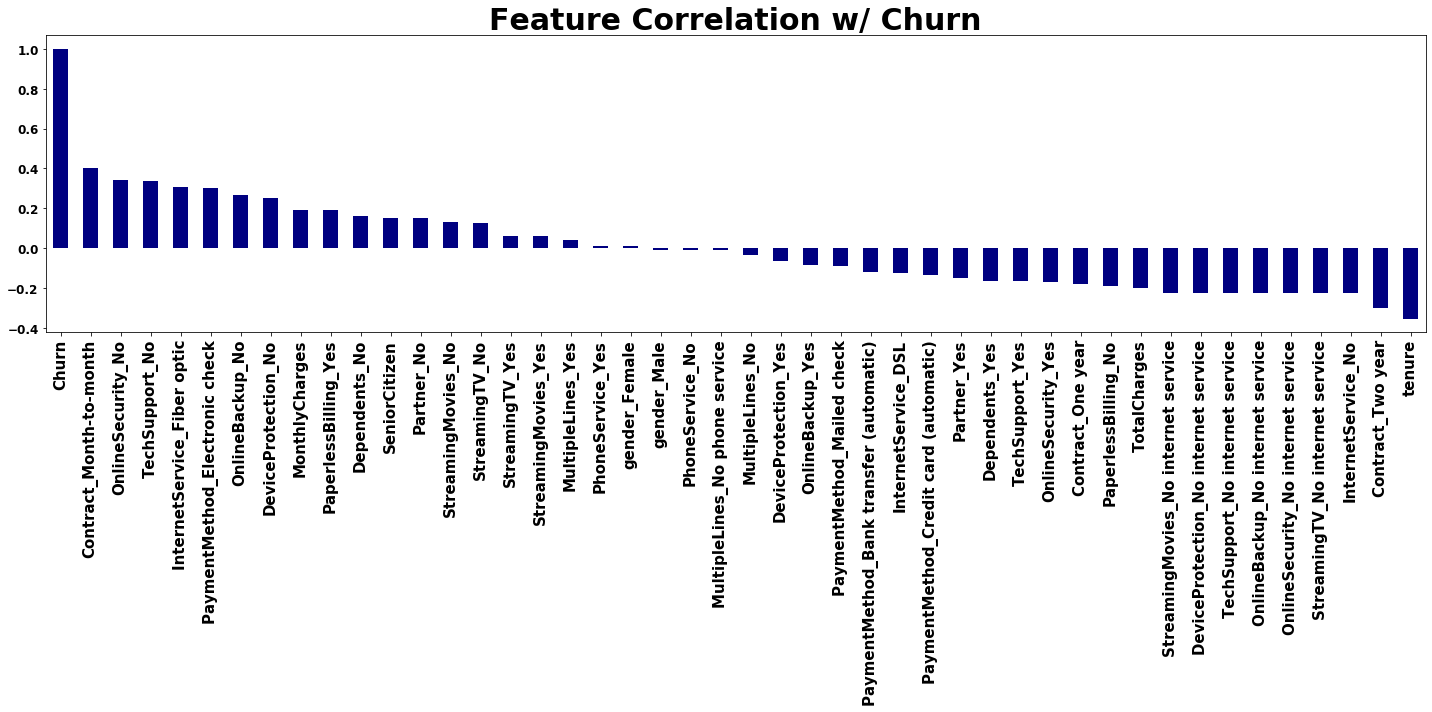

In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Plot correlations between our features and our target feature, churn, as a bar plot, sort by descending order
dummy_df.corr()['Churn'].sort_values(ascending = False).plot('bar', figsize = (20, 10), color = 'Navy')
plt.title('Feature Correlation w/ Churn', fontsize = 30, fontweight = 'bold')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold',)
plt.tight_layout()

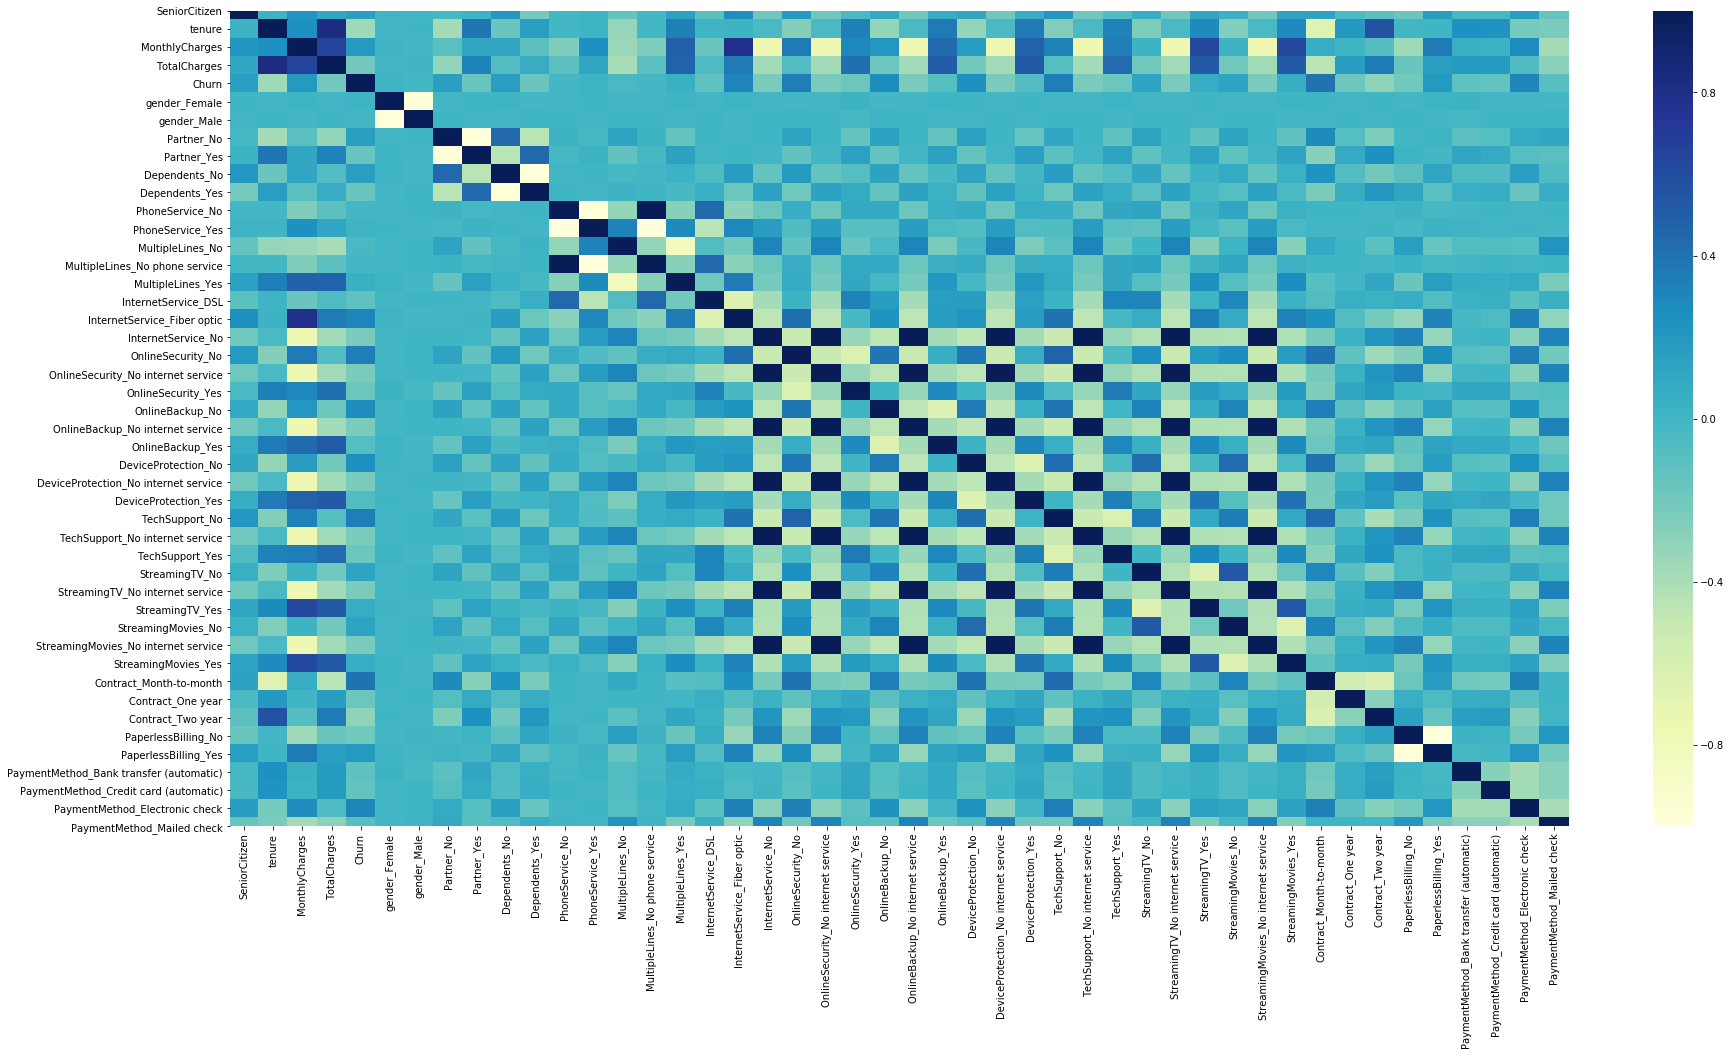

In [9]:
import seaborn as sns

# Visualize a heatmap for our features correlation values
plt.figure(figsize = (30, 15))
x = sns.heatmap(dummy_df.corr(), cmap = 'YlGnBu')

From our heatmap and correlation barplot, we see that monthly contract, and a lack of online security or techsupport have the strongest positive correlation with churn. 2-Year Contracts and not having internet service are the most negatively correlated with churn.

## Building the Model

### Splitting the data into Target and Input Variables

Separate the data into target feature ('y' variable) as "Churn" and predictive features ('X' variables) as all the other features except "Churn".

In [10]:
# Establish our target feature, churn, as our y feature
y = dummy_df.Churn.values
# Drop our target feature from our features dataframe
X = dummy_df.drop('Churn', axis = 1)
# Save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

Note, we have taken all the predictors in this case. This is normally called "kitchen sink" approach. This can create issues such as multi-collinearity in case two 'x' variables are highly correlated. This can be found by looking at the p-value of the coeeficients or parameters for each predictor and removing the variables which are not significant to improve the model performance.

### Scaling the data

All data has all numeric values now. Comparing a binary value [0,1] with continous values will not given relevant information because they all have different units. We can normalise all the data between [0,1] using Min-Max scaling to address this issue.

In [11]:
# Import the necessary sklearn method
from sklearn.preprocessing import MinMaxScaler

# Instantiate min-max scaling object
mm = MinMaxScaler()
# Fit and transform our feature dataframe
X = pd.DataFrame(mm.fit_transform(X))
# Reassign column names so new dataframe has corresponding names
X.columns = cols

X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.000000,0.115423,0.001275,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.464789,0.385075,0.215867,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.014085,0.354229,0.010310,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.619718,0.239303,0.210241,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.014085,0.521891,0.015330,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Splitting data into Training and Validation Sets

We will now split data into training and validation sets with 70% data used to build the model and rest 30% data held back to evaluate the model performance.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 33)

## Logistic Regression

### Logistic Function

Logistic regression is widely used for binary classification problems. Logistic function (or sigmoid function) is used at the core of this algorithm. 

Logistic function is an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits: 

                                               1 / (1 + e^-value)   
![](img/Logistic-Function.png)

### Logistic Regression Equation

Logistic regression gives the predicted output as probability of success class. Logistic regression is denoted by the equation:

                                   p(X) = e^(b0 + b1*X) / (1 + e^(b0 + b1*X))
where,
p(X) is the predicted output or probability of success class, 
b0 is the bias or intercept term and 
b1 is the coefficient for the input variable (X). 
Each column or variable in the input data has an associated 'b' coefficient (a constant real value) thatis learned from the training data.

Logistic regression is indeed a linear method, but the predictions are transformed using the logistic function. 
Rearranging the above equation, we get: 
                                        
                                        ln(p(X) / 1 – p(X)) = b0 + b1 * X
where, left-hand side is the log-odds of the success class and right-hand side is the linear combination of inputs or predictors.

Since the logistic regression output gives probabilities, we can use these probabilities to give the binary class (0 or 1) with 1 as the success class based on cutoff probability (say, 0.5) such as:

                                        0 if p(X)<0.5 and 1 if p(X)>0.5

### Fitting the Model

Let's fit the Logistic Regression Model on our training data.

In [13]:
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model with default parameters
logreg = LogisticRegression(random_state=33)
# Fit the model to our X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=33, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

As above, model is fit using default parameters. These parameters can be changed to improve the model accuracy. 

Let's start with default parameters and understood how the model performs. We can use any random state so that the model gives the same output on running the model at different iterations. Here, we have set the random state=33, however it can be any whole number.

At this point, our model is actually completely built and can be used for predicting the outputs. Let’s take a look at evaluating our performance.

### Evaluating Model Performance

#### Accuracy

How many times the model is able to predict correctly. It is calculated as:

                            Accuracy = # Successful predictions / Total # of datapoints

In [14]:
print("train accuracy: ",round(logreg.score(X_train,y_train),3))
print("test accuracy: ", round(logreg.score(X_test,y_test),3))

train accuracy:  0.806
test accuracy:  0.8


Since the model accuracy is equally good on test data (held back or unseen data) as on training data (on which model is fitted), our model is performing well. Also, accuracy is ~80% which is quite good and can be optimised further by changing the parameters while fitting the model.

#### Confusion Matrix

It is used to depict the number of observation in each of the four classes:

1. True Positives (TP) - Model predicted customer would churn (1) and they actually do churn (1)
2. True Negatives (TN) - Model predicted customer wouldn't churn (0) and they actually don't churn (0)
3. False Positives (FP) - Model predicted customer would churn (1) and they actually don't churn (0)
4. False Negatives (FN) - Model predicted customer wouldn't churn (0) and they actually do churn (1)

Depending on the situation, each of these have different weightages. In this case, false negatives are more important to pay attention to as it is worse for us to predict customer not churning (and hence not taking any preventive action) when actual in real life customer churns, losing the potential revenue.

In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Pass actual test and predicted target test outcomes to function
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1399  162]
 [ 261  288]]


From the above connfusion matrix, we can see that: TP=1399, FP=162, TN=288, FN=261. In order to derive more insights from these absolute numbers, we can use classification report and produce more descriptive metrics.

#### Classification Report

Precision: How many times the customer actually churned in real life out of all the times the model predicted customer would churn.

                        Precision = True Positives / Predicted Positives = TP/ (TP + FP)
                        
Recall: How many times the model is able to correct predict the customer would churn out of the total times customer churned in real life.
                           
                           Recall = True Positives / Total Positives = TP/ (TP + FN)
                           
F1 Score: a single indicator to capture both precision and recall - harmonic mean of precision and recall. Penalised model heavily if it is skewed towards precision or recall.

                               F1 = 2(Precision * Recall)/(Precision + Recall)
                               
Precision tells us how precise the predictions are, whereas recall tells the percentage of success class captured correctly by the model.

In [16]:
#Classification Report
from sklearn.metrics import classification_report 

print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1561
           1       0.64      0.52      0.58       549

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110



As we can see, precision for success class (churn=1) is quite low at 64% i.e. only 64% of the customers predicted to be churned actually churn. Recall at 52% is also bit lower and means that we are able to predict only 52% of the customers who would actually churn accurately. However, accuracy is quite high at 80%. Model building is an iterative process and these metrics can be further improved by changing the model parameters.

#### Receiver Operator Characteristic Curve (ROC Curve) and Area Under Curve (AUC)

ROC is a visual graph between True Positive Rate (recall - TPR) and False Positive Rate (FPR).

                  True Positive Rate = TP/ (TP+FN); False Positive Rate = FP/ (TN+FP)                  

The AUC will give us a singular numeric metric to compare instead of a visual representation. An AUC = 1 would represent a perfect classifier, and an AUC = 0.5 represents a classifier which only has 50% precision. This metric quantifies the overall accuracy of our classifier model.

Let's plot the AUC curve and find the AUC for our classifier!

Best performing models will have an ROC curve that hugs the upper left corner of the graph. This would represent that we correctly classify the positives much more often than we incorrectly classify them. The dotted line in the graph represents a 1:1 linear relationship and is representative of a bad classifier, because the model guesses one incorrectly for every correct guess.

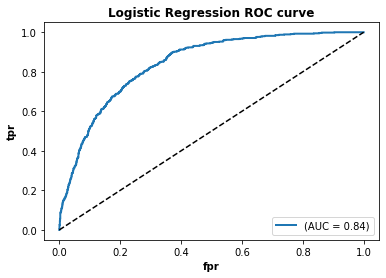

In [17]:
#ROC Curve and AUC Metric
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

y_hat_test_proba = logreg.predict_proba(X_test)[:,1] # get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba,pos_label=1)
roc_auc= round(auc(fpr, tpr),2)
plt.plot(fpr, tpr,lw=2,label='(AUC = {})'.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.xlabel('fpr',fontweight='bold')
plt.ylabel('tpr',fontweight='bold')
plt.title('Logistic Regression ROC curve', fontweight='bold')
plt.show()

ROC curve is plotted by calculating the TPR and FPR at different cutoff probabilities. As we can that there is a tradeoff between TPR and FPR. We can increase TPR by increasing the cutoff probability, but FPR would also continue to increase. The best model is where TPR is high and FPR is low, i.e., which stays towards the upper left corner.

Notice how test curve hug the upper left corner and has very strong AUC value. With such strong model, we can now turn our eyes to tuning some model parameters/hyperparameters to slowly elevate our scores.

## Decision Tree

Decision Trees are popular classification alogorithms, though they are also be used in predictive regression problems. 

The representation of decision tree model is a binary tree. A node of the tree represents a single input variable (X) and a split point on that variable, assuming the variable is numeric. The leaf nodes (also called terminal nodes) of the tree contain an output variable (y) which is used to make a prediction.

Once created, a tree can be navigated with a new row of data following each branch with the splits until a final prediction is made.

### Splitting the Tree

With more than one attribute taking part in the decision-making process, it is necessary to decide the relevance and importance of each of the attributes, thus placing the most relevant at the root node and further traversing down by splitting the nodes. As we move further down the tree, the level of impurity or uncertainty decreases, thus leading to a better classification or best split at every node. To decide the same, splitting measures such as Information Gain, Gini Index, etc. are used.

#### Gini Index

Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen.

If all the elements belong to a single class, then it can be called pure. The degree of Gini index varies between 0 and 1, where 0 denotes that all elements belong to a certain class or if there exists only one class, and 1 denotes that the elements are randomly distributed across various classes. A Gini Index of 0.5 denotes equally distributed elements into some classes.

Let's say we have a variable named Gender (Male and Female) each having 5 entries. 2 males out of 5 churned and 5 females out of 5 churned. 
    
    Gini Index = P(Male)*{1- P(Churn|Male)^2 - P(No Churn|Male)^2} + P(Female)*{1- P(Churn|Female)^2 - P(No Churn|Female)^2}
    Gini Index = (5/10)*{1 - (2/5)^2 - (3/5)^2} + (5/10)*{1 - (5/5)^2 - (0/5)^2}
    Gini Index = 0.5*0.48 + 0.5*0 = 0.24
    
Thus, the variable with the least gini index is placed at the root node and similarly the tree is transversed till leaf nodes by placing other features having lower gini index above the others with higher gini index . Also, root node is most important in classification based on this reason.

### Building the Model

Let's fit the decision tree model on our training data! We had already defined input and output variables and split the data into training and test sets before running Logistic Regression, so no need to repeat those steps here.

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate a Decision Tree model with default parameters
dt = DecisionTreeClassifier(max_depth=3,random_state=33)
# Fit the model to our X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33, splitter='best')

As above, model is fit using default parameters. These parameters can be changed to improve the model accuracy. 

Let's start with default parameters and understood how the model performs. We can use any random state so that the model gives the same output on running the model at different iterations. Here, we have set the random state=33, however it can be any whole number. Also, max depth is taken as 3 which means data will be split till three levels. If we don't choose this, there will be overfitting of the data and model performance on the test data will be poor.

### Evaluating Model Performance

#### Accuracy

In [19]:
print("train accuracy: ",round(dt.score(X_train,y_train),3))
print("test accuracy: ", round(dt.score(X_test,y_test),3))

train accuracy:  0.792
test accuracy:  0.788


Model performance is good as test data accuracy is nearly same as training data accuracy.

#### Confusion Matrix

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Pass actual test and predicted target test outcomes to function
y_hat_test = dt.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1466   95]
 [ 353  196]]


From the above confusion matrix, we can see that: TP= 1466, FP=95, TN=196, FN=353.

#### Classification Report

In [21]:
#Classification Report
from sklearn.metrics import classification_report 

print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1561
           1       0.67      0.36      0.47       549

    accuracy                           0.79      2110
   macro avg       0.74      0.65      0.67      2110
weighted avg       0.77      0.79      0.76      2110



For the success class i.e.Churn=1, recall is pretty low. Churn prediction out of total cases which actually churned is only 36%. Hence, this leads to not taking proper action on other cases which churned but we predicted to be not churning. The model needs to be improved by tuning the parameters/ hyper-parameters.

#### Receiver Operator Characteristic Curve (ROC Curve) and Area Under Curve (AUC)

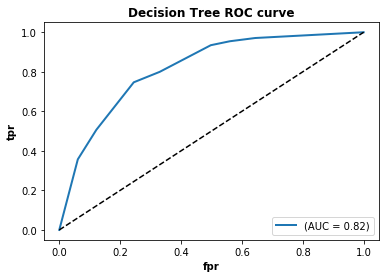

In [22]:
#ROC Curve and AUC Metric
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

y_hat_test_proba = dt.predict_proba(X_test)[:,1] # get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba,pos_label=1)
roc_auc= round(auc(fpr, tpr),2)
plt.plot(fpr, tpr,lw=2,label='(AUC = {})'.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.xlabel('fpr',fontweight='bold')
plt.ylabel('tpr',fontweight='bold')
plt.title('Decision Tree ROC curve', fontweight='bold')
plt.show()

Area under curve is quite good at 0.82.

### Visualisation of Decision Tree Model

Scikit-Learn library provides a nice framework to see how the tree is formed and what all attributes/ features are used while splitting the tree.

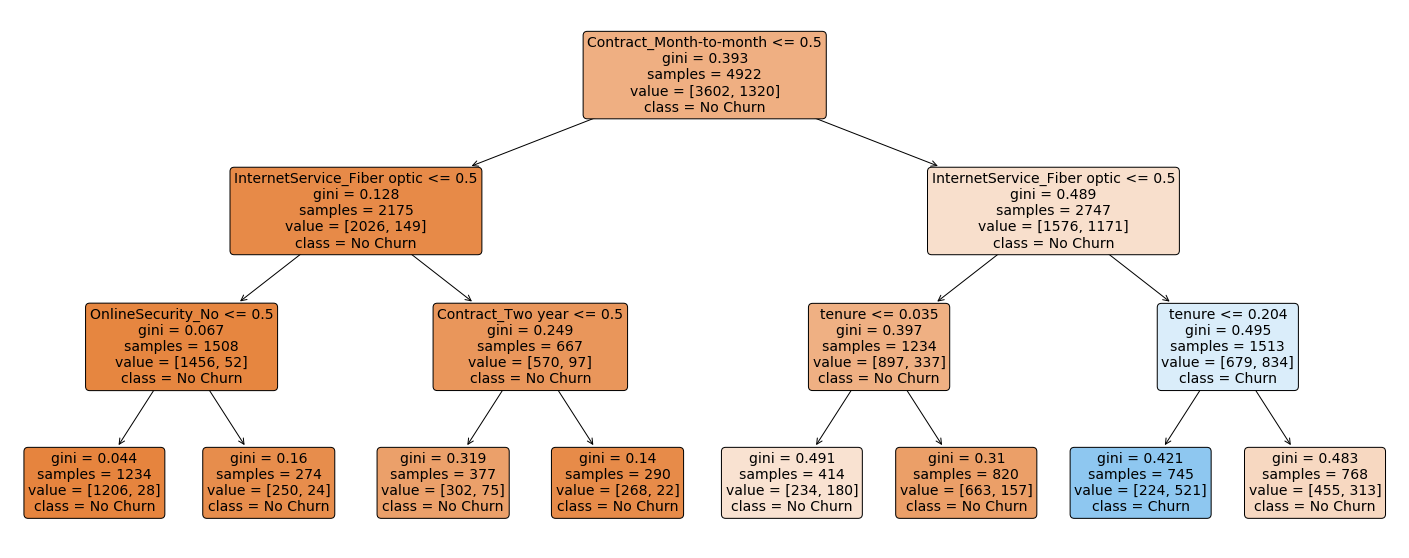

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25,10))
target=['No Churn', 'Churn']
a = plot_tree(dt,
              feature_names=cols,
              class_names=target,
              filled=True, 
              rounded=True, 
              fontsize=14)

From the above tree, we can see that Contract_Month-to-month is the most important feature in deciding the customer churn. Customers with Month-to-month contract <=0.5 (i.e 0) are split on LHS and customers with month-to-month contract >0.5 (i.e. 1) are split on RHS. Gini index for this variable is 0.393. Similarly, this is done for internal nodes or branches of the trees. At the leaf nodes we can see that predicted class is shown based on which class the majority values are falling. We can see For the leaf node on the extreme right, we can see that 455 values fall in "No Churn" and 313 in "Churn", hence the node class is predicted as "No Churn". However, the probability of error is quite high here. Hence, we can improve the model performance by changing the parameters by fitting the model such as max_depth, splitting_criterion, min_samples_split, etc.

## Limitations

1. Model is built on default parameters. The model performance can be improved by changing the parameters. Cross validaion and grid search is a technique which can be used to find the parameters which gives maximum model accuracy.
2. All the features/ variables are used in Logistic Regression Model. The model performance can be improved by using only features which are highly correlated with churn. Also, in case two features are having higher correlation with each other, one of them can be included while building the model.

## Conclusion

The model performance is quite good in the first round as we achieved ~80% accuracy. However, model building is an iterative process. We have woeked on only two classification algorithms - Logostic Regressiona and Decision Tree in this blog. We can also try different classification modeling algorithms such as Support Vector Machine (SVM), Random Forest, XGBoost to check if the model performance improves. I will work on these algorithms in the next series of blogs.

If you have any comments or suggestions please comment below or reach out to me at - [Twitter](https://twitter.com/rahulsingla0959) or [LinkedIn](https://www.linkedin.com/in/rahul-singla1/)

## References

[1] https://scikit-learn.org/stable/modules/preprocessing.html

[2] https://machinelearningmastery.com/logistic-regression-for-machine-learning/

[3] https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

[4] https://blog.quantinsti.com/gini-index/